# Analysis of adaptivity to hyperparameters changes

In [1]:
%load_ext autoreload
%autoreload 2

## Imports


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import torch

In [4]:
import numpy as np
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt

In [5]:
import logging, sys, gc
logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
    force=True,
)

In [6]:
import sys
sys.path.append("../")

In [7]:
from conditioning_common import sample_from_net
import import_export
import grids
from examples import configs

In [8]:
from bnn import SingleHiddenLayerWideNNWithLearnablePriorsAndActivation
from conditioning_on_varying_lengthscale import create_generator_matern_gp

# Analyse an example result

### Configuration

In [9]:
net_width = 128

In [10]:
# # activation=NN(SiLU), good matching GP, but only close to origin results 
# path = "../pretrained/train_ls0_w_a0_x8_results.json"  # random seed=0

# activation=NN(Periodic): good matching GP 
path = "../pretrained/train_ls0_w_a0_x8_periodic_results.json"  

### Load priors


In [11]:
results = import_export.load_from_json(path, target_net_width=net_width)

params = results["parameters"]
hypernet = params["hypernet"]
activation = params["activation"]

### Loss

In [12]:
try:
    history = pd.DataFrame(results["history"])
except:
    history = pd.DataFrame(eval(results["history"]))

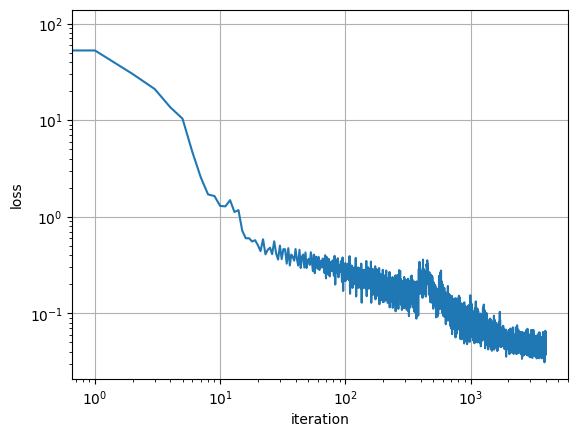

In [13]:
plt.plot(history["iteration"], history["loss"])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

In [14]:
loss_func = results["config"]["loss_func"]
num_function_samples = results["config"]["num_function_samples"]
batch_size = results["config"]["batch_size"] 
input_n_dims = results["config"]["input_n_dims"]
net = results["net"]

hypernet_input_builder = (
            lambda train_grid_x, batch_target, generator_hyperparams: generator_hyperparams["lengthscale"]
        )


### Activation

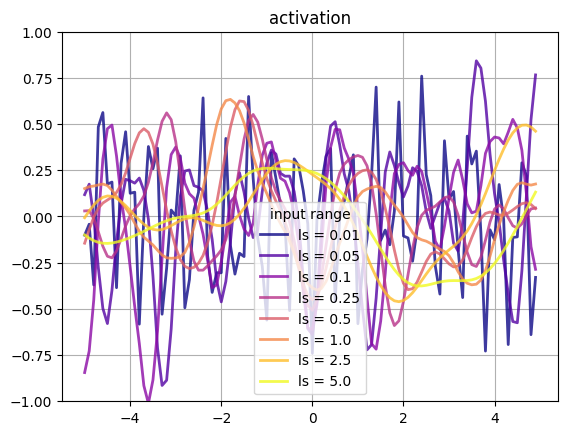

19289

In [15]:

lengthscales = [0.01, 0.05,  0.1, 0.25, 0.5, 1.0, 2.5, 5.0]
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, len(lengthscales)))
x = torch.arange(-5, 5, 0.1)
for i, lengthscale in enumerate(lengthscales):
        # Retrieve conditioning        
        hypernet_output = hypernet(torch.tensor(lengthscale))        
        activation_params = hypernet_output[:-1]
        priors_params = hypernet_output[-1].flatten()

        label=f"ls = {lengthscale}"
        plt.plot(x.detach().numpy(), activation(x, activation_params).detach().numpy(), color=colors[i], lw=2.0, label=label, alpha=0.8)
plt.title("activation");
plt.grid(True)
plt.legend(title="input range")
plt.ylim(-1,1)
plt.show()

gc.collect()

### Conditioning output

In [16]:
from weights_sampling import constraints

In [17]:
for i, lengthscale in enumerate(lengthscales):
    hypernet_output = hypernet(torch.tensor(lengthscale))     
    # print(hypernet_output, constraints.make_positive(hypernet_output[-1][0]))
    print(f"Learned variances for ls={lengthscale}:\t", " ".join([f"{v.item():.2f}" for i, v in enumerate(constraints.make_positive(hypernet_output[-1][0])) if i%2==1]))

Learned variances for ls=0.01:	 0.42 0.85 1.50 0.04
Learned variances for ls=0.05:	 0.41 0.88 1.43 0.06
Learned variances for ls=0.1:	 0.45 0.91 1.36 0.07
Learned variances for ls=0.25:	 0.54 0.91 1.19 0.10
Learned variances for ls=0.5:	 0.57 0.90 1.11 0.13
Learned variances for ls=1.0:	 0.60 0.89 1.04 0.16
Learned variances for ls=2.5:	 0.66 0.76 0.91 0.23
Learned variances for ls=5.0:	 0.68 0.74 0.88 0.26


In [18]:
net = SingleHiddenLayerWideNNWithLearnablePriorsAndActivation(width=net_width, indim=input_n_dims)

### Export plots

In [19]:
def plot_samples_for_lengthscale(ax1, ax2, lengthscale = 0, batch_size=4, data_min_x=-3, data_max_x=+3):

    input_grid_x = grids.create_sampled_uniform_grid(
                        data_min_x=data_min_x,
                        data_max_x=data_max_x, 
                        n_nodes=num_function_samples,
                        n_dims=input_n_dims,
                    )
    
    hypernet_input_builder = lambda a,b,c: torch.tensor(float(lengthscale))

    batch_learning = sample_from_net(
                    net=net,
                    hypernet=hypernet,
                    activation=activation,
                    hypernet_input_builder=hypernet_input_builder,
                    batch_size=batch_size,
                    input_grid_x=input_grid_x,
                    zero_locations=True,
                    batch_target=None,
                    target_hyperparams=None
                )
    plt.sca(ax1)
    gp = create_generator_matern_gp(lengthscale=lengthscale)
    batch_target = gp(input_grid_x, n_samples=batch_size)
    # plt.title(f"target (GP with lengthscale={lengthscale})")
    plt.plot(input_grid_x[:,0].cpu().detach().numpy(), batch_target.cpu().detach().numpy(), color="dodgerblue") 
    y1, y2 = plt.ylim()
    y1, y2 = y1*1.25, y2*1.25    
    plt.ylim(y1, y2)
    plt.ylabel(f"lengthscale={lengthscale}")    
    
    plt.sca(ax2)            
    plt.plot(input_grid_x[:,0].cpu().detach().numpy(), batch_learning[:batch_size,:].T.cpu().detach().numpy(), color="orange");
    # plt.title(f"samples from trained conditioned distribution for lengthscale={lengthscale}")
    # plt.title(f"lengthscale={lengthscale}")
    plt.ylim(y1, y2)


    gc.collect()
    
    return input_grid_x

In [20]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fontsize = 14

[2024-10-17 16:28:13,797] {python/lib/python3.8/site-packages/matplotlib/font_manager.py:1350} WARNING - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
[2024-10-17 16:28:13,813] {python/lib/python3.8/site-packages/matplotlib/font_manager.py:1350} WARNING - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


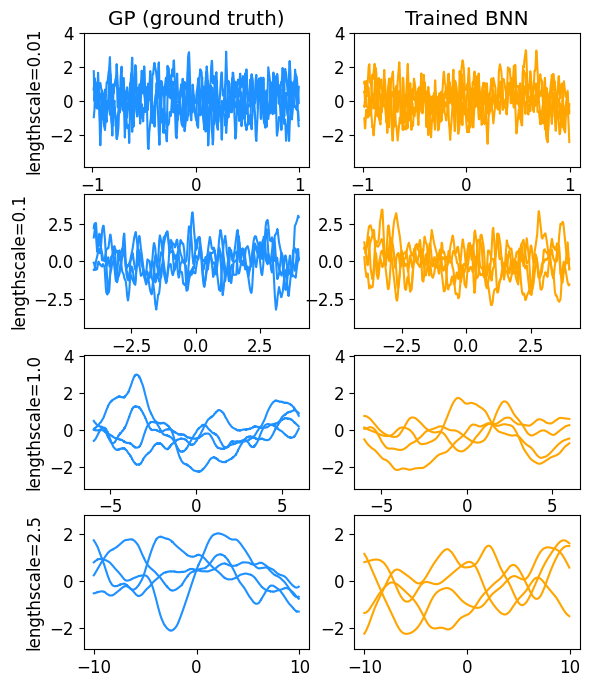

In [21]:
fig = plt.figure(figsize=(6.4, 8.0))
axes = fig.subplots(nrows=4, ncols=2)
plt.sca(axes[0,0])
plt.title("GP (ground truth)")
plt.sca(axes[0,1])
plt.title("Trained BNN")
plot_samples_for_lengthscale(axes[0,0], axes[0,1], 0.01, 4, -1, 1);
plot_samples_for_lengthscale(axes[1,0], axes[1,1], 0.1, 4, -4, 4);
plot_samples_for_lengthscale(axes[2,0], axes[2,1], 1.0, 4, -6, 6);
plot_samples_for_lengthscale(axes[3,0], axes[3,1], 2.5, 4, -10, 10);
# plt.savefig("experiments_conditioning_on_lengthscale_preview.pdf",  bbox_inches='tight')#, pad_inches=0.5)

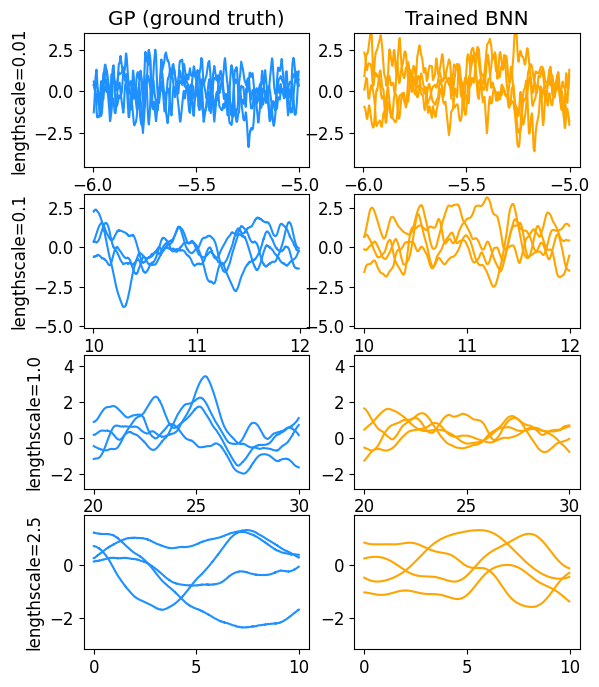

In [22]:
fig = plt.figure(figsize=(6.4, 8.0))
axes = fig.subplots(nrows=4, ncols=2)
plt.sca(axes[0,0])
plt.title("GP (ground truth)")
plt.sca(axes[0,1])
plt.title("Trained BNN")
plot_samples_for_lengthscale(axes[0,0], axes[0,1], 0.01, 4, -6, -5);
plot_samples_for_lengthscale(axes[1,0], axes[1,1], 0.1, 4, 10, 12);
plot_samples_for_lengthscale(axes[2,0], axes[2,1], 1.0, 4, 20, 30);
plot_samples_for_lengthscale(axes[3,0], axes[3,1], 2.5, 4, 0, 10);
# plt.savefig("experiments_conditioning_on_lengthscale_preview.pdf",  bbox_inches='tight')#, pad_inches=0.5)